In [1]:
import dgl
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from KGCN import Model, loss_fn
from sklearn.metrics import roc_auc_score
from util import Group

Using backend: pytorch


In [2]:
def process_graph(graph: dgl.heterograph):
    number_of_users = graph.num_nodes('user')
    number_of_repos = graph.num_nodes('repo')
    ground_truth = torch.zeros((number_of_users, number_of_repos), dtype=torch.int8)
    user_repo = torch.zeros((number_of_users, number_of_repos), dtype=torch.int8)
    for etype in graph.canonical_etypes:
        # ignore the reverse relation
        if etype[0] != 'user' and etype[1] != 'repo':
            continue

        edges = graph.edges(etype=etype)

        ground_truth[edges[0], edges[1]] = 1
        user_repo[edges[0], edges[1]] = 1
    
    repos_per_user = torch.sum(user_repo, axis=1)

    return ground_truth, repos_per_user.numpy()

In [3]:
def process_edge_data(graph, edge_data):
    number_of_users = graph.num_nodes('user')
    number_of_repos = graph.num_nodes('repo')
    ratings = np.zeros((number_of_users, number_of_repos))
    for etype in graph.canonical_etypes:
        # ignore the reverse relation
        if etype[0] != 'user' and etype[1] != 'repo':
            continue
        
        edges = graph.edges(etype=etype)
        data = torch.squeeze(edge_data[etype]).numpy()
        ratings[edges[0], edges[1]] = np.maximum(ratings[edges[0], edges[1]], data)
    
    return ratings

In [4]:
def compute_auc(graph, pos_score, neg_score):
    auc_scores = []
    for etype in graph.canonical_etypes:
        # ignore the reverse relation
        if etype[0] != 'user' and etype[1] != 'repo':
            continue
        
        pos_data = torch.squeeze(pos_score[etype])
        neg_data = torch.squeeze(neg_score[etype])
        
        scores = torch.cat([pos_data, neg_data]).numpy()
        labels = torch.cat(
            [torch.ones(pos_data.shape[0]), torch.zeros(neg_data.shape[0])]).numpy()

        auc_score = roc_auc_score(labels, scores)

        auc_scores.append(auc_score)
    
    return np.mean(auc_scores)

In [7]:
training_results = []

EPOCH = 100
TOP_K = 10
NEG_SAMPLE_SIZE = 5
USER_INPUT_SIZE = 150
REPO_INPUT_SIZE = 361
USER_REPO_OUTPUT_SIZE = 125
HIDDEN_OUTPUT_SIZE = 96
OUT_SIZE = 50

g, l = dgl.load_graphs('./data/sub_kowledge_graph.bin')
train_graph = g[0]
valid_graph = g[1]
test_graph = g[2]
train_pos_g = g[3]
train_neg_g = g[4]
valid_pos_g = g[5]
valid_neg_g = g[6]
test_pos_g = g[7]
test_neg_g = g[8]

model = Model(train_graph, USER_INPUT_SIZE, REPO_INPUT_SIZE, USER_REPO_OUTPUT_SIZE, HIDDEN_OUTPUT_SIZE, OUT_SIZE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

ground_truth_valid_data, repos_per_user_valid = process_graph(valid_graph)
ground_truth_test_data, repos_per_user_test = process_graph(test_graph)

for epoch in range(EPOCH):
    training_loops = 0
    total_loss = 0

    user_feat = train_graph.ndata['graph_data']['user']
    repo_feat = train_graph.ndata['graph_data']['repo']
    model.train()
    pos_score, neg_score = model(train_graph, train_pos_g, train_neg_g, user_feat, repo_feat)
    loss = loss_fn(pos_score, neg_score, NEG_SAMPLE_SIZE)

    total_loss += loss.item()
    training_loops += 1

    # Backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_avg_loss = total_loss / training_loops

    if epoch % 5 == 0:
        # valid top k recommendation
        model.eval()
        with torch.no_grad():
            # hit rate
            valid_mean_hit_rate = 0
            valid_group_hit_rate = {}
            hit_rates = np.zeros(valid_graph.num_nodes('user'))
            hit_rate_groups = Group()

            # MRR
            valid_mrr = 0
            valid_group_mrr = {}
            mrr = np.zeros(valid_graph.num_nodes('user'))
            mrr_groups = Group()

            h_user = model.user_embedding(train_graph.ndata['graph_data']['user'])
            h_repo = model.repo_embedding(train_graph.ndata['graph_data']['repo'])

            h_dict = {
                'user': h_user,
                'repo': h_repo
            }

            h = model.hidden(train_graph, h_dict)
            out = model.out(train_graph, h)

            prediction = model.predict(valid_graph, out)
            user_repo_rating = process_edge_data(valid_graph, prediction)

            for i, rating in enumerate(user_repo_rating):
                recommendation = rating.argsort()[::-1][:TOP_K]
                index_sorted = ground_truth_valid_data[i].argsort()
                filter_index = ground_truth_valid_data[i][index_sorted] > 0
                ground_truth = index_sorted[filter_index]

                intersections, recommendation_index, ground_truth_index = np.intersect1d(recommendation, ground_truth, return_indices=True)
                number_of_intersections = len(intersections)
                number_of_ground_truth = len(ground_truth)

                # hit rate
                hit_rate = -1 if number_of_ground_truth == 0 else number_of_intersections / min(number_of_ground_truth, TOP_K)
                hit_rates[i] = min(hit_rate, 1)

                # MRR
                if number_of_intersections > 0:
                    if recommendation_index[0] <= TOP_K:
                        mrr[i] = 1 / (recommendation_index[0] + 1)
                else:
                    mrr[i] == -1

                # grouping
                if repos_per_user_valid[i] < 5:
                    hit_rate_groups['0-5'].append(i)
                    mrr_groups['0-5'].append(i)
                elif repos_per_user_valid[i] < 10:
                    hit_rate_groups['5-10'].append(i)
                    mrr_groups['5-10'].append(i)
                elif repos_per_user_valid[i] < 15:
                    hit_rate_groups['10-15'].append(i)
                    mrr_groups['10-15'].append(i)
                else:
                    hit_rate_groups['15-over'].append(i)
                    mrr_groups['15-over'].append(i)

            # hit rate mean
            valid_mean_hit_rate = np.mean(hit_rates[hit_rates>-1])
            for group_name, group_indices in hit_rate_groups.items():
                valid_group_hit_rate[group_name] = np.mean(hit_rates[group_indices][hit_rates[group_indices]>-1])

            # mrr mean
            valid_mrr = np.mean(mrr[mrr>-1])
            for group_name, group_indices in mrr_groups.items():
                valid_group_mrr[group_name] = np.mean(mrr[group_indices][mrr[group_indices]>-1])

        # test top k recommendation
        model.eval()
        with torch.no_grad():
            # hit rate
            test_mean_hit_rate = 0
            test_group_hit_rate = {}
            hit_rates = np.zeros(test_graph.num_nodes('user'))
            hit_rate_groups = Group()

            # MRR
            test_mrr = 0
            test_group_mrr = {}
            mrr = np.zeros(test_graph.num_nodes('user'))
            mrr_groups = Group()

            h_user = model.user_embedding(train_graph.ndata['graph_data']['user'])
            h_repo = model.repo_embedding(train_graph.ndata['graph_data']['repo'])

            h_dict = {
                'user': h_user,
                'repo': h_repo
            }

            h = model.hidden(train_graph, h_dict)
            out = model.out(train_graph, h)

            prediction = model.predict(test_graph, out)
            user_repo_rating = process_edge_data(test_graph, prediction)

            for i, rating in enumerate(user_repo_rating):
                recommendation = rating.argsort()[::-1][:TOP_K]
                index_sorted = ground_truth_test_data[i].argsort()
                filter_index = ground_truth_test_data[i][index_sorted] > 0
                ground_truth = index_sorted[filter_index]

                intersections, recommendation_index, ground_truth_index = np.intersect1d(recommendation, ground_truth, return_indices=True)
                number_of_intersections = len(intersections)
                number_of_ground_truth = len(ground_truth)

                # hit rate
                hit_rate = -1 if number_of_ground_truth == 0 else number_of_intersections / min(number_of_ground_truth, TOP_K)
                hit_rates[i] = hit_rate

                # MRR
                if number_of_intersections > 0:
                    if recommendation_index[0] <= TOP_K:
                        mrr[i] = 1 / (recommendation_index[0] + 1)
                else:
                    mrr[i] == -1

                # grouping
                if repos_per_user_test[i] < 5:
                    hit_rate_groups['0-5'].append(i)
                    mrr_groups['0-5'].append(i)
                elif repos_per_user_test[i] < 10:
                    hit_rate_groups['5-10'].append(i)
                    mrr_groups['5-10'].append(i)
                elif repos_per_user_test[i] < 15:
                    hit_rate_groups['10-15'].append(i)
                    mrr_groups['10-15'].append(i)
                else:
                    hit_rate_groups['15-over'].append(i)
                    mrr_groups['15-over'].append(i)

            # hit rate mean
            test_mean_hit_rate = np.mean(hit_rates[hit_rates>-1])
            for group_name, group_indices in hit_rate_groups.items():
                test_group_hit_rate[group_name] = np.mean(hit_rates[group_indices][hit_rates[group_indices]>-1])

            # mrr mean
            test_mrr = np.mean(mrr[mrr>-1])
            for group_name, group_indices in mrr_groups.items():
                test_group_mrr[group_name] = np.mean(mrr[group_indices][mrr[group_indices]>-1])

        # conpute the AUC score
        auc_score = 0
        model.eval()
        with torch.no_grad():
            h_user = model.user_embedding(train_graph.ndata['graph_data']['user'])
            h_repo = model.repo_embedding(train_graph.ndata['graph_data']['repo'])

            h_dict = {
                'user': h_user,
                'repo': h_repo
            }

            h = model.hidden(train_graph, h_dict)
            out = model.out(train_graph, h)

            pos_score = model.predict(test_pos_g, out)
            neg_score = model.predict(test_neg_g, out)

            auc_score = compute_auc(train_graph, pos_score, neg_score)

        epoch_results = [
            epoch, 
            train_avg_loss, 
            auc_score,
            valid_mean_hit_rate, 
            test_mean_hit_rate, 
            valid_mrr,
            test_mrr
        ]
            
        for name, value in valid_group_hit_rate.items():
            epoch_results.append(value)
        
        for name, value in valid_group_mrr.items():
            epoch_results.append(value)
            
        for name, value in test_group_hit_rate.items():
            epoch_results.append(value)
        
        for name, value in test_group_mrr.items():
            epoch_results.append(value)
            
        training_results.append(epoch_results)
        
        

In [13]:
data_columns = [
    'epoch', 
    'loss', 
    'auc',
    'valid hit rate', 
    'test hit rate',
    'valid MRR',
    'test MRR'
]

for name, value in valid_group_hit_rate.items():
    data_columns.append('hit rate valid group ' + name)

for name, value in valid_group_mrr.items():
    data_columns.append('MRR valid group ' + name)

for name, value in test_group_hit_rate.items():
    data_columns.append('hit rate test group ' + name)

for name, value in test_group_mrr.items():
    data_columns.append('MRR test group ' + name)

data = pd.DataFrame(training_results, columns=data_columns)

In [14]:
data

,epoch,loss,auc,valid hit rate,test hit rate,valid MRR,test MRR,hit rate valid group 0-5,hit rate valid group 5-10,hit rate valid group 10-15,...,MRR valid group 10-15,MRR valid group 15-over,hit rate test group 0-5,hit rate test group 10-15,hit rate test group 5-10,hit rate test group 15-over,MRR test group 0-5,MRR test group 10-15,MRR test group 5-10,MRR test group 15-over
0,0,0.238630,0.571416,0.766288,0.774147,0.301955,0.297328,0.751053,0.889482,0.973214,...,0.433447,0.381085,0.759055,0.942105,0.916011,0.966667,0.291480,0.407665,0.441580,0.548602
1,5,0.070531,0.646385,0.744076,0.741157,0.313527,0.305360,0.767710,0.486586,0.462500,...,0.525935,0.577447,0.765469,0.461404,0.458010,0.695238,0.295993,0.520927,0.573654,0.439078
2,10,0.049862,0.655663,0.744845,0.742843,0.314766,0.306244,0.768442,0.488648,0.462500,...,0.529358,0.567196,0.766412,0.461404,0.475401,0.695238,0.295876,0.508208,0.628623,0.442630
3,15,0.043205,0.684887,0.745637,0.745145,0.312426,0.306124,0.765147,0.543037,0.503571,...,0.527941,0.462963,0.764526,0.492982,0.540537,0.695238,0.295915,0.501455,0.616046,0.482785
4,20,0.040394,0.705463,0.742083,0.741475,0.309477,0.304342,0.761029,0.554594,0.501786,...,0.445422,0.374537,0.761413,0.468421,0.551316,0.638095,0.295012,0.467781,0.590968,0.491780
5,25,0.038616,0.718049,0.743928,0.741757,0.309462,0.302883,0.761303,0.551244,0.505357,...,0.457249,0.320216,0.759951,0.521053,0.553796,0.633333,0.293972,0.468240,0.579995,0.442177
6,30,0.037166,0.713431,0.745400,0.743998,0.311668,0.304062,0.763683,0.551244,0.494643,...,0.466128,0.331173,0.763724,0.489474,0.552437,0.614286,0.295287,0.462225,0.582169,0.431122
7,35,0.035833,0.710607,0.742597,0.740259,0.310020,0.303963,0.762676,0.544534,0.473214,...,0.497307,0.310802,0.761460,0.454386,0.538941,0.614286,0.295012,0.455082,0.596299,0.423186
8,40,0.034664,0.706618,0.740852,0.739845,0.311190,0.303961,0.762310,0.536189,0.455357,...,0.537018,0.339198,0.762120,0.438596,0.532751,0.590476,0.295522,0.468992,0.570937,0.393027
9,45,0.033576,0.704585,0.740977,0.738348,0.310006,0.303283,0.763134,0.528457,0.448214,...,0.535778,0.359568,0.760988,0.433333,0.532751,0.561905,0.295012,0.452109,0.577277,0.371599


Text(0.5, 1.0, 'Loss per epoch')

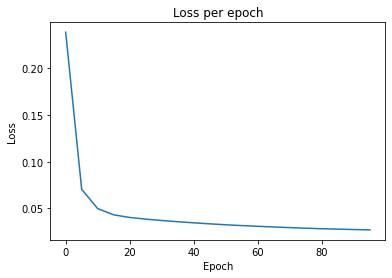

In [10]:
plt.plot(data['epoch'], data['loss'], label='loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per epoch')

Text(0.5, 1.0, 'AUC per epoch')

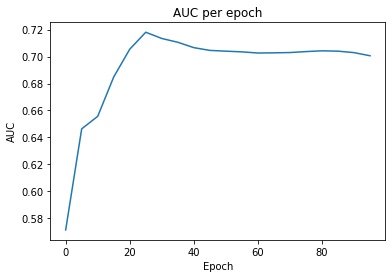

In [11]:
plt.plot(data['epoch'], data['auc'], label='auc')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('AUC per epoch')

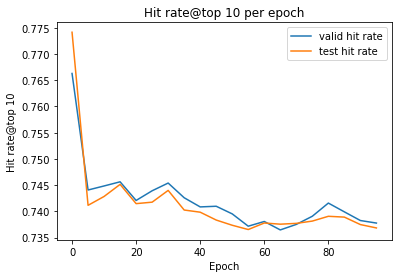

In [12]:
plt.plot(data['epoch'], data['valid hit rate'], label='valid hit rate')
plt.plot(data['epoch'], data['test hit rate'], label='test hit rate')
plt.xlabel('Epoch')
plt.ylabel('Hit rate@top 10')
plt.title('Hit rate@top 10 per epoch')
plt.legend()

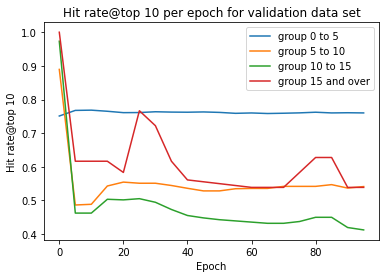

In [16]:
plt.plot(data['epoch'], data['hit rate valid group 0-5'], label='group 0 to 5')
plt.plot(data['epoch'], data['hit rate valid group 5-10'], label='group 5 to 10')
plt.plot(data['epoch'], data['hit rate valid group 10-15'], label='group 10 to 15')
plt.plot(data['epoch'], data['hit rate valid group 15-over'], label='group 15 and over')
plt.xlabel('Epoch')
plt.ylabel('Hit rate@top 10')
plt.title('Hit rate@top 10 per epoch for validation data set')
plt.legend()

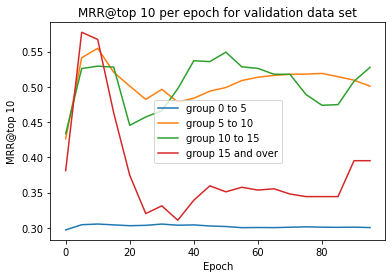

In [19]:
plt.plot(data['epoch'], data['MRR valid group 0-5'], label='group 0 to 5')
plt.plot(data['epoch'], data['MRR valid group 5-10'], label='group 5 to 10')
plt.plot(data['epoch'], data['MRR valid group 10-15'], label='group 10 to 15')
plt.plot(data['epoch'], data['MRR valid group 15-over'], label='group 15 and over')
plt.xlabel('Epoch')
plt.ylabel('MRR@top 10')
plt.title('MRR@top 10 per epoch for validation data set')
plt.legend()

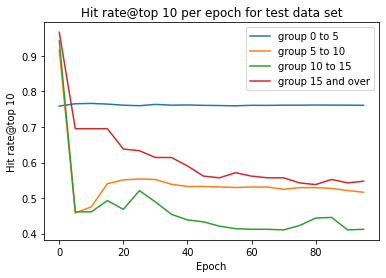

In [17]:
plt.plot(data['epoch'], data['hit rate test group 0-5'], label='group 0 to 5')
plt.plot(data['epoch'], data['hit rate test group 5-10'], label='group 5 to 10')
plt.plot(data['epoch'], data['hit rate test group 10-15'], label='group 10 to 15')
plt.plot(data['epoch'], data['hit rate test group 15-over'], label='group 15 and over')
plt.xlabel('Epoch')
plt.ylabel('Hit rate@top 10')
plt.title('Hit rate@top 10 per epoch for test data set')
plt.legend()

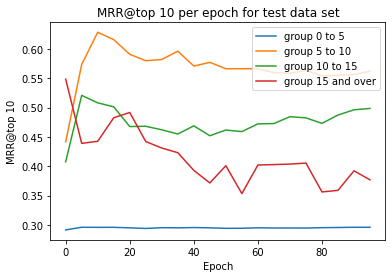

In [20]:
plt.plot(data['epoch'], data['MRR test group 0-5'], label='group 0 to 5')
plt.plot(data['epoch'], data['MRR test group 5-10'], label='group 5 to 10')
plt.plot(data['epoch'], data['MRR test group 10-15'], label='group 10 to 15')
plt.plot(data['epoch'], data['MRR test group 15-over'], label='group 15 and over')
plt.xlabel('Epoch')
plt.ylabel('MRR@top 10')
plt.title('MRR@top 10 per epoch for test data set')
plt.legend()